In [1]:
import pandas as pd
import numpy as np

import boto3
from sagemaker import get_execution_role

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

<h1> Overview </h1>

[Link](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/overview)

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest
mobile market in the world and therefore suffers from huge volumes of fraudulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!



In [2]:
# Pandas can only determine what dtype a column should have once the whole file is read. 
# This means nothing can really be parsed before the whole file is read so don't guess dtypes here

dtypes = dict(ip='int64', app='int64', device='int64', os='int64', channel='int64', click_time='object', is_attributed='int64')

usecols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

In [3]:
# Load data from Amazon S3

role = get_execution_role()
bucket = 'talkingdata-fraud'

# Side note: I initially went through this exercise using only the sample csv which is much smaller than the actual train.csv.
# After cleaning up the work flow, I was able to scale up the sagemaker instance appropriately for the data so that I would
# not run into any more memory errors.

# data_key = 'train_sample.csv'
data_key = 'train.csv'
data_location = 's3://{}/{}'.format(bucket,data_key)

# using the latter half of the training data for more recent data

df = pd.read_csv(data_location, skiprows=range(1,123903891), nrows=61000000,
                 usecols=usecols, dtype=dtypes, parse_dates=['click_time'])


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61000000 entries, 0 to 60999999
Data columns (total 7 columns):
ip               int64
app              int64
device           int64
os               int64
channel          int64
click_time       datetime64[ns]
is_attributed    int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 3.2 GB


<h1>Data fields</h1>

Each row of the training data contains a click record, with the following features.


* ip: ip address of click.
* app: app id for marketing.
* device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click (UTC)
* attributed_time: if user download the app for after clicking an ad, this is the time of the app download
* is_attributed: the target that is to be predicted, indicating the app was downloaded

In [5]:
def sniff(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['sample'] = df.iloc[0]
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        return info.sort_values('data type')

sniff(df)

,sample,data type,percent missing
ip,210014,int64,0.0
app,9,int64,0.0
device,1,int64,0.0
os,13,int64,0.0
channel,334,int64,0.0
click_time,2017-11-08 16:41:52,datetime64[ns],0.0
is_attributed,0,int64,0.0


In [6]:
# Convert datetime to usable columns

df['day'] = df['click_time'].dt.day# create train and test ofyear
df['dayofweek'] = df['click_time'].dt.dayofweek
df['hour'] = df['click_time'].dt.hour

In [7]:
# Counting clicks by ip would probably be a good indicator of target

ip_clicks = df.groupby(['ip']).count().reset_index()
ip_clicks = ip_clicks[['ip','app']]
ip_clicks.columns = ['ip', 'clicks_per_ip']
df = pd.merge(df, ip_clicks, on='ip', how='left', sort=False)
df.head()

,ip,app,device,os,channel,click_time,is_attributed,day,dayofweek,hour,clicks_per_ip
0,210014,9,1,13,334,2017-11-08 16:41:52,0,8,2,16,616
1,2076,3,1,32,211,2017-11-08 16:41:52,0,8,2,16,15918
2,296481,9,1,19,232,2017-11-08 16:41:52,0,8,2,16,354
3,33473,15,1,13,245,2017-11-08 16:41:52,0,8,2,16,3030
4,115014,3,1,13,137,2017-11-08 16:41:52,0,8,2,16,1535


In [8]:
del ip_clicks

In [9]:
# Create train and test split, set stratify = yes as the target is vastly disproportional 
# so that we can preserve the original percentages

df['is_attributed'].value_counts()

0    60849867
1      150133
Name: is_attributed, dtype: int64

<h3> Side note </h3>

You may have noticed by now that I did not one-hot encode or .astype('category') on the categorical variables. OHE causes the instance to run into memory issues, and some reading has suggested that it is not vital in tree-based algorithms. Ideally the algorithm will see the categorical variables as multimodal and make decent splits anyways, so we'll see how the model performs. If anyone has any solutions to this issue other than not using Sagemaker built-in algorithms, please feel free to message me about it! 

In [133]:
from sklearn.model_selection import train_test_split

# remember not to include IP from train and validation sets 

train_columns = ['app', 'device', 'os', 'channel', 
                'day', 'dayofweek', 'hour', 'clicks_per_ip']

y = df.pop('is_attributed')

X = df[train_columns]

# del df

# Train is for training model, val is used for validating the model, test is for testing the deployed model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

In [136]:
# Convert train and validation data sets to a format per AWS documentation:
# 1. Move the target attribute to the first position
# 2. No index and headers

pd.concat([y_train, X_train], axis=1).to_csv('xgb_train.csv', index=False, header=False)
pd.concat([y_val, X_val], axis=1).to_csv('xgb_validation.csv', index=False, header=False)

# Upload csv files to S3

boto3.Session().resource('s3').Bucket(bucket).Object('xgb_train.csv').upload_file('xgb_train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('xgb_validation.csv').upload_file('xgb_validation.csv')

In [144]:
# We will be using the built-in XGBoost algorithm

from sagemaker.amazon.amazon_estimator import get_image_uri

import sagemaker

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/xgb_train.csv'.format(bucket), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/xgb_validation.csv'.format(bucket), content_type='csv')


# Create a training job name
job_name = 'talkingdata-xgboost-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

# Store model artifact in the s3 bucket
output_location = 's3://{}/xgboost_output'.format(bucket)

In [145]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.2xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

# Remember to set objective and evaluation metric to a parameter appropriate for our target
# We will be using area under the curve for evaluation as this is a classification problem

xgb.set_hyperparameters(objective='binary:logistic', eval_metric='auc', num_round = 1)

data_channels = {
    'train':s3_input_train,
    'validation':s3_input_validation
}

xgb.fit(data_channels, job_name = job_name)

2020-03-05 21:54:09 Starting - Starting the training job...
2020-03-05 21:54:12 Starting - Launching requested ML instances......
2020-03-05 21:55:13 Starting - Preparing the instances for training...
2020-03-05 21:55:55 Downloading - Downloading input data...
2020-03-05 21:56:28 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','

2020-03-05 21:56:48 Training - Training i

We can see that the auc score is .934, which is generally considered outstanding, without one hot encoding the categorical variables too!

In [146]:
model = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

In [148]:
from sagemaker.predictor import json_deserializer, csv_serializer

model.content_type = 'text/csv'
model.serializer = csv_serializer
model.deserializer = None



test_X = X_test.values

# Not sure why connection is ending prematurely for predictions and would only accept around 1/100 of the test data at a time
# If anyone knows how to fix this issue, please feel free to email me! This is my current workaround:

block_size = len(test_X)//100


def predict_decode_test(test_data):
    results = model.predict(test_data)
    # Results are returned as bytes so we need to decode it
    results = np.fromstring(results.decode('utf-8'), sep=',')
    return results

results = np.array([])
for num in range(100):
    start = block_size*num
    end = block_size*(num+1)
    results = np.append(results,predict_decode_test(test_X[start:end]))

accuracy: 0.9978390163934426
precision: 0.6629873598006053
recall: 0.24805168853660162
auc score: 0.6238702975103537


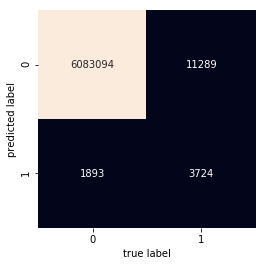

In [149]:
# In-depth look at our precision and accuracy score

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

threshold = 0.50
predicted = results >= threshold


accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)
auc = roc_auc_score(y_test, predicted)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

print("auc score:", auc)

<h3>Final Thoughts</h3>

This exercise should demonstrate how to train and deploy a model without the need of a local machine. Interesting to note that my data for testing the deployed model has a significant lower auc score than the validation auc score. I would investigate this further to find out why that is when the validation data yields a higher score during training, unless it's just a matter of the target inequality.

There are probably more interesting features that I can extract from the data, such as time between clicks for IPs or performing cartesian product transformations on the app/device/os variables.

Another algorithm could also be used to increase the AUC score such as LightGBM which allows you to select columns as categorical for one of its parameters. It is unfortunate that AWS does not have LGBM as a built-in algorithm for Sagemaker, but we can use ECS to load our own algorithms or simply install it in Jupyter if you don't require the ability of scaling instances for training.

Lastly, it is possible to grid search through a wide range of parameters and values and run training jobs in parallel with each other to optimize the model, but this is all coming out of my pocket and I'm not trying to incur too much costs with this.